# An Exponential Modeling Approach to covid-19 cases prediction.

The general handling of the data and exploratory analysis is presented in the EDA notebook.

In this notebook you will find:

1. Fitting Simple Exponential Growth Models
2. Logistic Growth
3. Richard Growth Equation
4. Logistic Sigmoid Growth
5. Comparison of Logistic, Richard and Logistic Sigmoid
6. Conclusions

In [1]:
# required imports
from datetime import timedelta
from math import sqrt

import pandas as pd
from scipy.stats import poisson
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.metrics import r2_score

# created package see the folder growth_modeling in this repo.
from growth_modeling import ExponentialGrowth
from growth_modeling import ExponentialGeneralizedGrowth
from growth_modeling import LogisticGrowth
from growth_modeling import RichardGrowth
from growth_modeling import LogisticSigmoidGrowth

%matplotlib inline

In [58]:
# retrieve the cases data from github
url = "https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/covid19_cases_switzerland_openzh.csv"
covid19_cases = pd.read_csv(url, parse_dates=['Date'], index_col='Date')

# df with only the cumulative count of cases (C(t))
ch_df = covid19_cases[['CH']].reset_index()
ch_df.rename({'CH': 'cumulative_cases'}, axis=1, inplace=True)

# create time column in days
starting_date = ch_df.Date.iloc[0]
ch_df['t'] = ch_df.Date.apply(lambda date: (date - starting_date).days)

# add a daily increase column from which to take the mean of the poisson RV..
ch_df['daily_increase'] = ch_df.cumulative_cases - ch_df.cumulative_cases.shift().fillna(0)

ch_df.head()

,Date,cumulative_cases,t,daily_increase
0,2020-02-25,1.0,0,1.0
1,2020-02-26,2.0,1,1.0
2,2020-02-27,4.0,2,2.0
3,2020-02-28,11.0,3,7.0
4,2020-02-29,14.0,4,3.0


In [60]:
# helper code used throughout the notebook put here for readability
def ax_growth_model(data, predictions, fit_up_to=0, subplot=111, asymptote=None):
    r"""create an matplotlib axes object to ease plotting growth models.
    
    Parameters
    ----------
    data : pd.Series
        a series with as values the observed cumulative number of cases and as index
        the time in days.
    predictions : array_like
        an array_like object containing predictions `pd.Series` made from a growth models
        **warning** the name of the series must be specified and a supplementary attribute
        `color` must be set.
    fit_up_to : int, optional
        the end slice to which the predictions model was fit to.
    subplot : int, optional
        argument passed to plt.subplot()
    asymptote : int, optional
        the asymptotic value of the growth model.
    
    Returns
    -------
    ax : pyplot.Axes
        an axes object with the correspondings plots.
    """
    ax = plt.subplot(subplot)
    
    days_to_date = lambda x: x.map(lambda item: ch_df.iloc[0].Date + timedelta(days=item)).values
    
    if fit_up_to != 0:
        data_fit = data[:fit_up_to]
        data_after_fit = data[fit_up_to:]
    else:
        data_fit = data
        data_after_fit = None
    
    ax.scatter(days_to_date(data_fit.index), data_fit.values, label="data used to fit model", color="r", marker='x')
    if data_after_fit is not None:
        ax.scatter(days_to_date(data_after_fit.index), data_after_fit.values, label="data not used to fit model", color="grey", marker='x')
    
    dates_for_axis = ch_df.Date.values
    for serie in predictions:
        d = days_to_date(serie.index)
        if max(d) > max(dates_for_axis):
            dates_for_axis = d
        ax.plot(days_to_date(serie.index), serie.values, label=serie.name, color=serie.color)
    
    if asymptote is not None:
        ax.hlines(asymptote, dates_for_axis[0], dates_for_axis[-1], color="grey", linestyle="--", label="aymptotic value")
    
    ax.legend()
    ax.set_xlabel('date (month/day)')
    ax.set_ylabel('Cumulative Number of Confirmed Cases')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.xticks(dates_for_axis, rotation=90)
    days_to_date(serie.index)
    ax.set_xlim((dates_for_axis[0], dates_for_axis[-1]))
    ax.set_ylim((0, 25000))
    ax.grid(True)

    return ax

def fit_growth_model(GrowthModel, params, bounds, t, y, name, color, fit_up_to=0, predict_up_to=0):
    r"""Fit a provided GrowthModel and return predicted values series.
    
    Parameters
    ----------
    GrowthModel : Growth
        one the Growth class implemented in growth_modeling.
    params : dict
        a dict of params to initialize the model with
    bounds : array_like
        bounded for each of the parameter (specified similarly as in scipy.optimize.curve_fit)
    t : array_like
        time values to fit the growth model on.
    y : array_like
        response values to fit the growth model on.
    name: str
        name of the model to fit.
    color: str
        a matplotlib color to put as attribute of the serie.
    fit_up_to : int, optional
        the end slice to which the predictions model was fit to.
    predict_up_to : int, optional
        the number of days to predict up to.
    """
    growth = GrowthModel(params.copy(), bounds)
    growth.y_0 = y[0]
    
    # -- FULL DATASET
    growth.fit(t, y)
    print("[OPTIMISED params (full dataset)]")
    print(growth.params)
    
    y_pred = growth.compute_y(t)
    print("R2 SCORE (full dataset): {}".format(r2_score(y, y_pred)))
    
    t_predict = np.array(range(predict_up_to)) if predict_up_to != 0 else t
    growth_serie = pd.Series(growth.compute_y(t_predict), name=name)
    growth_serie.color = color
    
    # -- REDUCED DATASET
    if fit_up_to != 0:
        growth.params = params.copy()
        growth.fit(t[:fit_up_to], y[:fit_up_to])
        print("\n[OPTIMISED params (dataset[:{}])]".format(fit_up_to))
        print(growth.params)
    
        y_pred = growth.compute_y(t)
        print("R2 SCORE (full dataset): {}".format(r2_score(y, y_pred)))
        
        y_pred = growth.compute_y(t[:fit_up_to])
        print("R2 SCORE (training dataset): {}".format(r2_score(y[:fit_up_to], y_pred)))
        
        y_pred = growth.compute_y(t[fit_up_to:])
        print("R2 SCORE (testing dataset): {}".format(r2_score(y[fit_up_to:], y_pred)))
    
        growth_serie_lim = pd.Series(growth.compute_y(t_predict), name=name)
        growth_serie_lim.color = color
        
        return (growth_serie, growth_serie_lim)
    
    return (growth_serie,)


### 1. Fitting Exponential Growth.

Since the data that we observe comes from virus spreading, a first logical guess at the trend the data should follow would be an exponential growth.

In this section, I tried to fit a simple exponential model first and a generalized exponential model allowing for "sub-exponential" with an added parameter.

The **simple exponential** model can be formally written as follow:

$\frac{\partial y}{\partial t} = ay \Leftrightarrow y = y_0 e^{at}$

where:
- $y$ is the observed response (the cumulative number of covid19 cases).
- $t$ is the time step (in days in our case).
- $a$ is the growth rate (relative derivative increase compared to the number of total cases reported).
- $y_0$ is the number of observe response at time $t = 0$.

The **generalized exponential** model can be formally written as follow:

$\frac{\partial y}{\partial t} = ay^p \Leftrightarrow y = [(1 - p)at + y_0^{1-p}]^{\frac{1}{1-p}}$

where all the parameters are identical and:
- $p$ is a parameter allowing sub-exponential regime ($0<p<1$).

Notice how this 2 models are modeling exponential growth as their derivative always depends on the current observed response $y$. The generalized exponential growth allows for a more flexible dependency with the current observed response $y$ by introducing a new parameter $p$ when $p$ is small this allows for sub-exponential regime where the growth is not as "strong" as in the regular exponential case.

This 2 models are now fitted to the whole dataset using non-linear least square optimisation to find the optimal parameters:

- for the simple case: $a = \arg\min_{a} \sum_{i=0}^{i=k}{(y_i - y_{exp})^2}$
- for the generalized case: $a, p = \arg\min_{a,p} \sum_{i=0}^{i=k}{(y_i - y_{exp})^2}$

where:
- $k$ is the number of value in the dataset.
- $y_i$ is the real response value from the dataset.
- $y_{exp}$ is the predicted value from the model using the closed-form solution above for $y$.

In [68]:
# fit the models using helper function and `growth_modeling` package.
t = ch_df.t.values
y = ch_df.cumulative_cases.values
fit_up_to = -16

# fit normal exponential
params = {"a": 0.2}
bounds = (0.0, 10.0)
exponential_predictions = fit_growth_model(ExponentialGrowth, params, bounds, t, y, "exponential growth", 'y', fit_up_to=fit_up_to)

print("")

# fit generalized exponential
params = {"a": 0.2, "p": 0.5}
bounds = (0.0, (10.0, 1.0))
exponential_generalized_predictions = fit_growth_model(ExponentialGeneralizedGrowth, params, bounds, t, y, "generalized exponential growth", 'g', fit_up_to=fit_up_to)

[OPTIMISED params (full dataset)]
{'a': 0.25912718031147863}
R2 SCORE (full dataset): 0.45024198417438777

[OPTIMISED params (dataset[:-16])]
{'a': 0.3707360372627217}
R2 SCORE (full dataset): -6558.90210767141
R2 SCORE (training dataset): 0.9565908635829524
R2 SCORE (testing dataset): -44541.84939951842

[OPTIMISED params (full dataset)]
{'a': 2.7369827980774333, 'p': 0.6296055129058881}
R2 SCORE (full dataset): 0.9825519933367127

[OPTIMISED params (dataset[:-16])]
{'a': 0.5990818585956731, 'p': 0.8956741613448884}
R2 SCORE (full dataset): -26.491595906634082
R2 SCORE (training dataset): 0.9982478240736733
R2 SCORE (testing dataset): -185.67223523034392


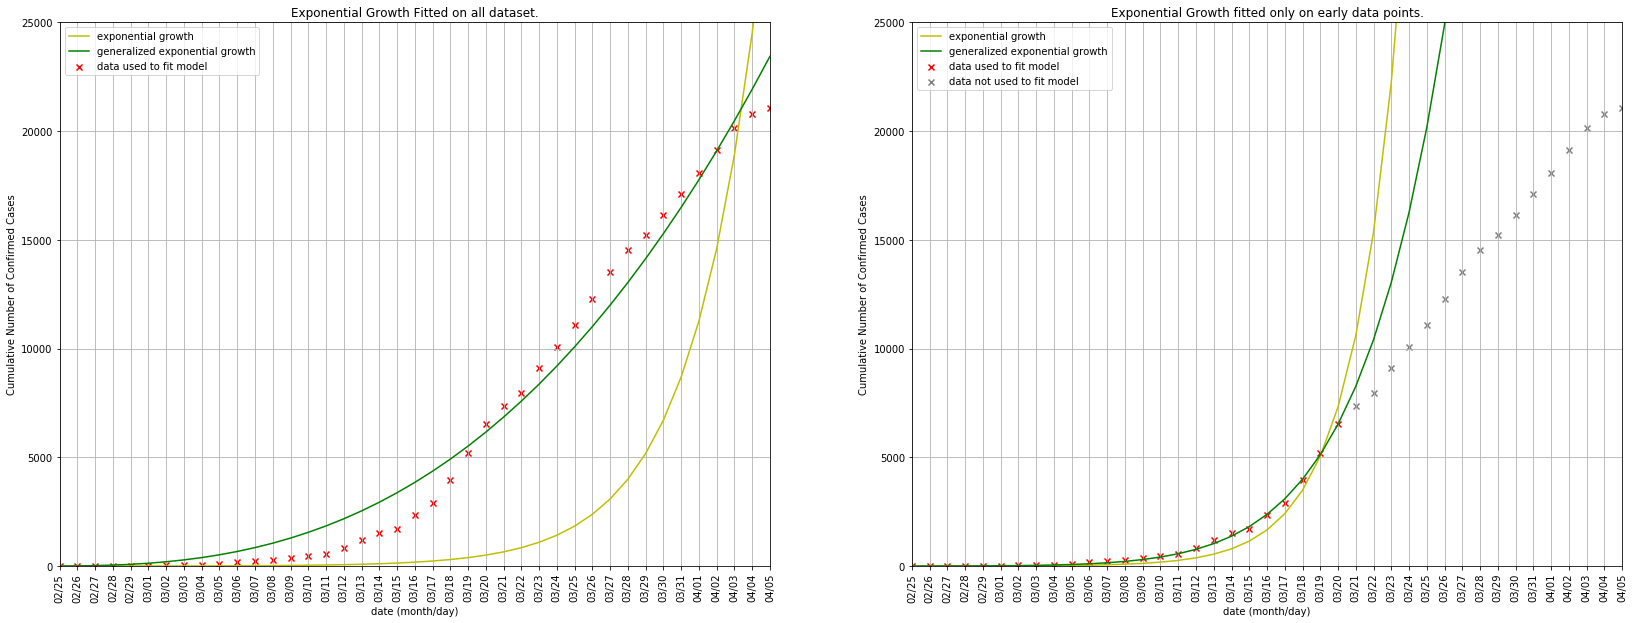

In [69]:
# plot the results
plt.figure(figsize=[28,10])

ax = ax_growth_model(ch_df.cumulative_cases, (exponential_predictions[0], exponential_generalized_predictions[0]), subplot=121)
ax.set_title('Exponential Growth Fitted on all dataset.')

ax = ax_growth_model(ch_df.cumulative_cases, (exponential_predictions[1], exponential_generalized_predictions[1]), fit_up_to=fit_up_to, subplot=122)
ax.set_title('Exponential Growth fitted only on early data points.')

plt.show()

**Observations**

few observations can be made from the 2 plots and R2 scores:
- when fitted on the whole dataset both exponential model don't seem to fit well the data. This is likely due to the decreasing rate at which new confirmed cases occur after some point.
- when fitted only on the first part of the dataset, we clearly observe a better fit from both model however it fails to capture the following trend (fail to predict the futur values).
- in both cases the generalized model allowing sub-exponential growth seems to perform better (more expressivity one more parameter also gives an edge to fitting the training data).

The conclusion we can make from theses observations are the following one:
- eventhough the overall trend of cumulative new cases can't be explained by a simple exponential growth, it seems that the early dynamic of the virus was nevertheless following an exponential trend.
- the generalized version of the exponential growth seems to outperform the simple exponential both in term of fit and in prediction of the futur values.

---

**next steps**
- since exponential not explaining the overall experiment with models that could explain this dataset (needs to allow a rate decrease at some point)
- use these model to predict futur values and if possible predict an asymptotic level of cases.

### 2. Fitting a Logistic Growth Model (LGM)

We observed that the overall trend of the data could not be fit properly using a simple exponential as the rate at which the virus spread seems to decay after some point.

Logistic growth model is the first answer to how to limit the maximum number a population can grow when this population is growing exponentially.

The model formally looks as follow:

$\frac{\partial y}{\partial t} = a y (1 - \frac{y}{K}) \Leftrightarrow y = \frac{K}{1+e^{-a(t-t_0)}}$

where:
- $y$ corresponds to the observed value (cumulative number of covid19 cases)
- $t$ corresponds to the time at which a value is observed
- $t_0$ is the time at which $y = K/2$
- $a$ is the relative growth rate it corresponds to the early growth rate of the exponential model but it also impact the decay in that case.
- $K$ is the asymptotic number the observed value can reach.

Notice that when $y$ is very small compared to $K$ the growth almost follows a simple exponential however as $y$ grow the factor $a (1-\frac{y}{K})$ get lower and lower which reduce the increase. Asymptotically when $y = K$ the increase rate becomes 0 which means the observed responses won't grow anymore.

Similarly as with the exponential growth models, we fit this this model using non-linear least square optimization. In this case the parameters fit are $a$, $t_0$ and $K$.

In [255]:
t = ch_df.t.values
y = ch_df.cumulative_cases.values

params = {"a": 1.0,"t_0": 15.0,"K": max(y)}
bounds = ((0.0, 0.0, max(y)), (10.0, 100.0, 100000.0))

logistic_predictions = fit_growth_model(LogisticGrowth, params, bounds, t, y, "logistic growth", "steelblue", fit_up_to=-5, predict_up_to=50)

[OPTIMISED params (full dataset)]
{'a': 0.2199205430555488, 't_0': 28.91425480361296, 'K': 22172.2420225552}
R2 SCORE (full dataset): 0.9973403723627051

[OPTIMISED params (dataset[:-5])]
{'a': 0.23327538042556373, 't_0': 28.101100152611604, 'K': 20489.000000000025}
R2 SCORE (full dataset): 0.9956802508264784
R2 SCORE (training dataset): 0.9970476032855243
R2 SCORE (testing dataset): 0.31413133174352126


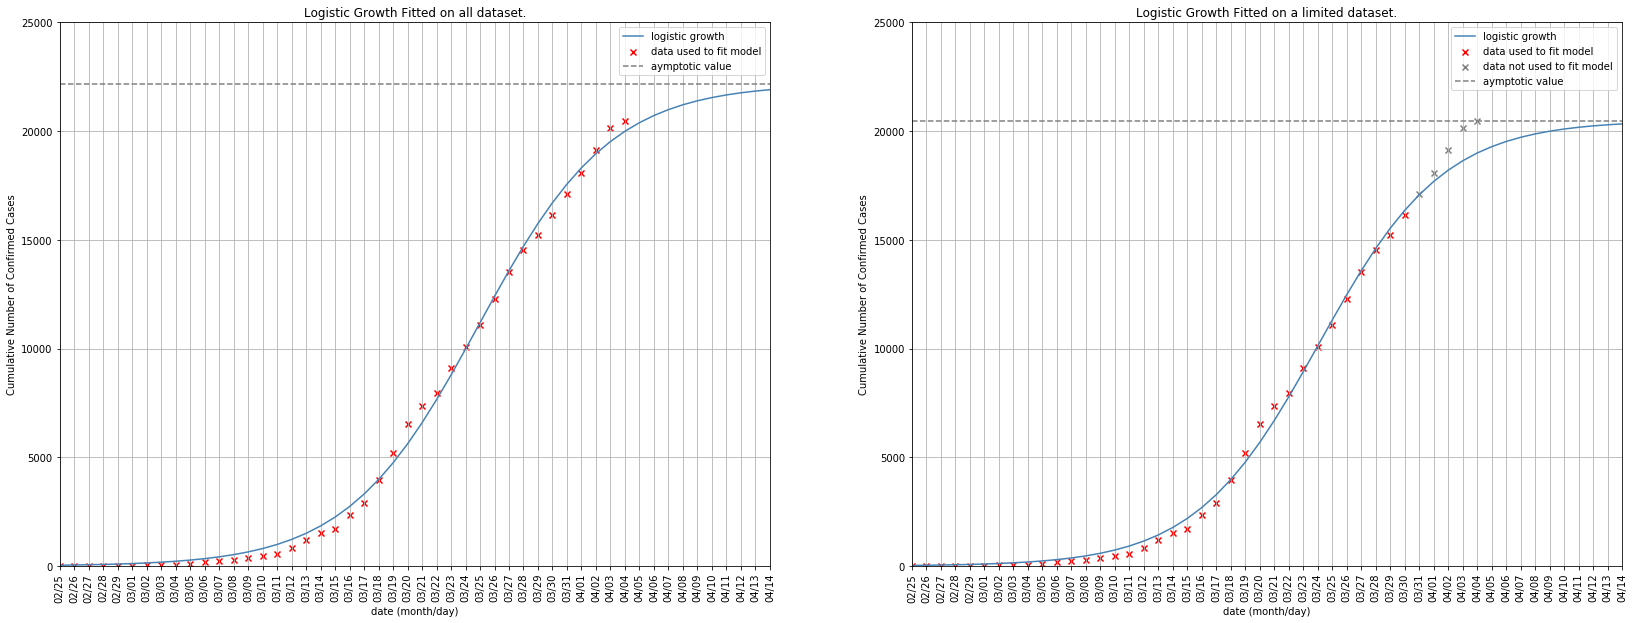

In [256]:
plt.figure(figsize=[28,10])

ax = ax_growth_model(ch_df.cumulative_cases, (logistic_predictions[0],), subplot=121, asymptote=22172)
ax.set_title('Logistic Growth Fitted on all dataset.')

ax = ax_growth_model(ch_df.cumulative_cases, (logistic_predictions[1],), subplot=122, fit_up_to=-5, asymptote=20489)
ax.set_title('Logistic Growth Fitted on a limited dataset.')

plt.show()

#### Observations

We observe a much better fit from the logistic model than from the exponential model both visually and in term of R2_score.

However we can also observe a high variability in the asymptotic value depending on the number of training point kept. This is probably due to the fact that the spike of the pandemic has not been reach and with each increase in the data the model fits a higher asymptotic level.

Based on this observations we can assume that the logistic growth will tend toward a minimum bound of our prediction has the asymptotic level fails to be well predicted before the spike of the pandemic is reached.

The simplicity of this model also brings some limitations for example the relative growth rate has to change linearly with the increase of infected cases. Another limitation is the symmetry aspect of the increase and decrease which leads to this "S" shape.

In order to improve this model, similarly to the exponential model we can allow for different rate of decay / increase by introducing a new parameter which is exactly what the "Richard model" was created for.

Another improvement is to allow for a non-symmetric growth / decay to occurs. This will be the "logistic sigmoid" approach.

---

#### Next Steps

- Improve the model with Richard Equation
- Improve the model with Logistic Sigmoid Growth


### 3. Richard Growth equation.

This section will be about fitting the Richard equation [1] to the number of covid-19 cases in Switzerland.

The Richard equation corresponds formally to the following:

$\frac{\partial y}{\partial t} = ay[1 - (\frac{y}{K})^b] \Leftrightarrow y = K(1 + e^{(d − abt)})^{−1/b}$

where:
- $y$ is the observed values in our case (the covid19 cases in Switzerland).
- $t$ is the time values for which to compute the observed values.
- $a$ is the maximum intrinsic rate of increase of the response.
- $b$ An additional parameter in the Richards equation introduced as a power law so that it can define asymmetric curves.
- $d$ A parameter in the Richards equation which allows the time at which y = K/2 to be varied.
- $K$ The upper asymptote of the response y.

The solution for $y$ assuming $a > 0$ and $b > 0$ is shown by Causton DR, Venus JC. 1981 [2].

This models improves the simplier logistic growth model by allowing asymmetric shape between the growth and decay of the logistic growth through the parameter $b$.

Similarly as previous approach, the parameters $a$, $b$, $d$ and $K$ will be fit through non-linear least-square optimisation.

**References**:

[1] Richards FJ. 1959. "A flexible growth function for empirical use." Journal of Experimental Botany 10: 290–300.

[2] Causton DR, Venus JC. 1981. "The biometry of plant growth." London: Edward Arnold.

In [70]:
# fit a richard growth model
t = ch_df.t.values
y = ch_df.cumulative_cases.values

params = {"a": 0.3, "b": 3.0, "d": 15.0, "K": 14000}
bounds = (0.0, (10.0, 10.0, 100.0, 1000000.0))

richard_predictions = fit_growth_model(RichardGrowth, params, bounds, t, y, "richard growth", "royalblue", fit_up_to=-5, predict_up_to=50)

[OPTIMISED params (full dataset)]
{'a': 2.396932869733132, 'b': 0.0454452015159814, 'd': 5.732268209658678e-14, 'K': 28053.920074604444}
R2 SCORE (full dataset): 0.9992362825130925

[OPTIMISED params (dataset[:-5])]
{'a': 0.8560533767762446, 'b': 0.15696569722992135, 'd': 1.81596830232262, 'K': 23990.162300916625}
R2 SCORE (full dataset): 0.9974097371351697
R2 SCORE (training dataset): 0.9989798980029235
R2 SCORE (testing dataset): 0.27069210728924686


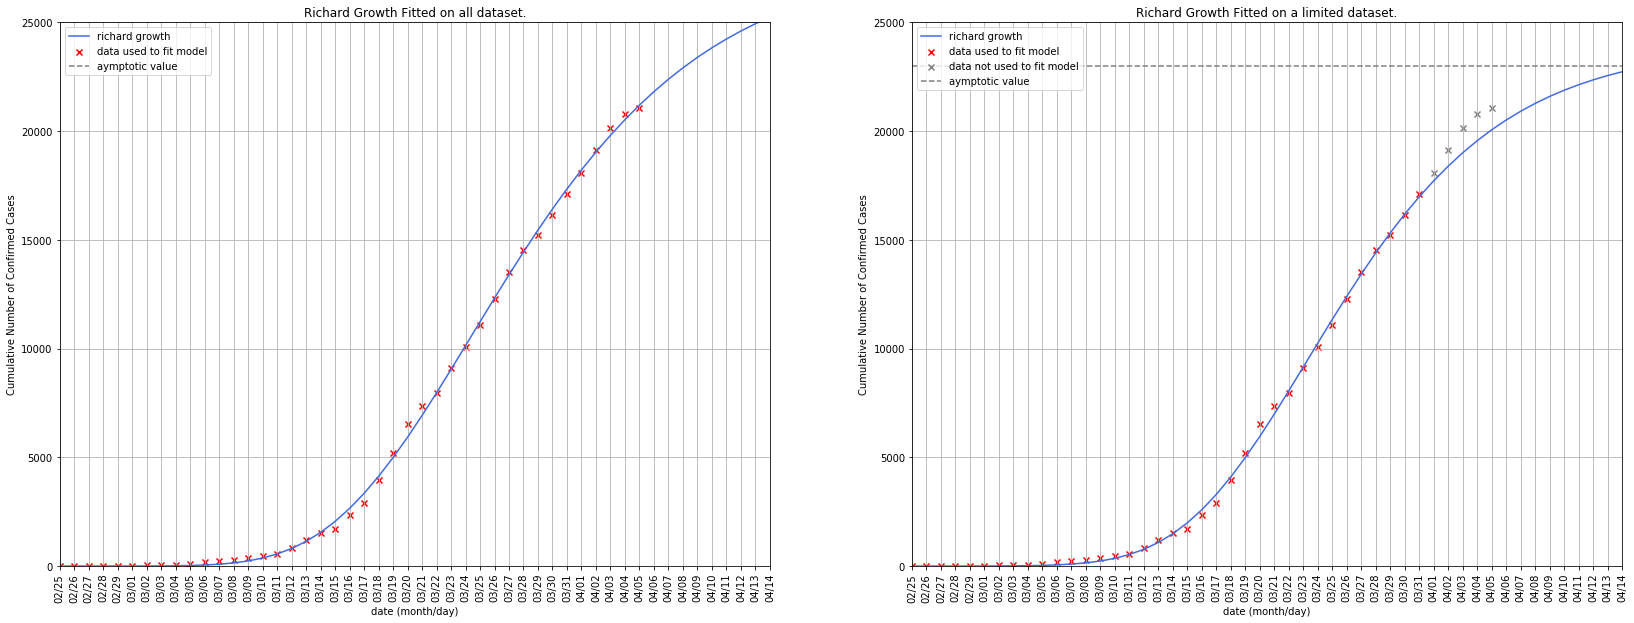

In [71]:
plt.figure(figsize=[28,10])

ax = ax_growth_model(ch_df.cumulative_cases, (richard_predictions[0],), subplot=121, asymptote=27882)
ax.set_title('Richard Growth Fitted on all dataset.')

ax = ax_growth_model(ch_df.cumulative_cases, (richard_predictions[1],), subplot=122, fit_up_to=-5, asymptote=22998)
ax.set_title('Richard Growth Fitted on a limited dataset.')

plt.show()

#### Observations

We can observe a slight improvement of the fit on the full dataset when using richard's equation compared to the logistic model. This was expected as we allow a better fit of our training with a more flexbile function with more parameters.

We also observe a 10% increase of the R2 score on the last 5 values when using the remaining values as training set which means that the better fitting also generalize to predictions.

However similarly to the logistic model it seems that the asymptotic upper level "K" varies a lot between the 2 training procedure which impact the accuracy of predictions on the next values.

It also seems that until we reach the spike of the spread of the virus, the predicted will tend to be a lower bound on the real number of cases.

#### Next Steps

A last attempt at modeling the number of cases of covid 19 in Switzerland will be to use another modified version of the logistic growth model.

### 4. logistic sigmoid growth equation

This model was originally introduced by Colin P. D. Birch. 1999 [3] as an attempt to generalized the logistic growth model while keeping an exponential growth at low densities.

The formal relation between the observed response and the time can be written as follow:

$\frac{\partial y}{\partial t} = \frac{ay(K-y)}{K-y+cy} \Leftrightarrow t - t_0 = \frac{\log(y) - c\log(K-y) + (c-1)\log(K/2)}{a}$

where:
- $y$ is the observed values (number of cases of covid19).
- $t$ the time at wich the values are observed.
- $a$ The maximum intrinsic rate of increase (RGR) of the observed values.
- $c$ An additional parameter in the new sigmoid equation introduced so that it can define asymmetric curves.
- $t_0$ time at which $y = K/2$.
- $K$ The upper asymptote of the response y.

The value of c from 0 upwards allows the maximum rate of growth to be at any value of y from 0 to K.

Notice that in this case since the equation has no closed form when solved for $y$ hence it is solved for $t$. This will lead to the following procedure to fit the model to the data:
- first numerically integrate the differential equation above
- then fit the parameters $a$, $c$, $K$ will be tuned using non-linear least-square optimization as previously done but on the time values.

**Reference**

[3] Colin P. D. Birch. 1999 "A New Generalized Logistic Sigmoid Growth Equation Compared with the Richards Growth Equation."

In [19]:
t = ch_df.t.values
y = ch_df.cumulative_cases.values

params = {"a": 0.3,"c": 3.0,"K": max(y)}
bounds = ((0.0, -10.0, max(y)), (10.0, 10.0, 1000000.0))

logistic_sig_predictions = fit_growth_model(LogisticSigmoidGrowth, params, bounds, t, y, "logistic sigmoid growth", "navy", fit_up_to=-5, predict_up_to=50)

[OPTIMISED params (full dataset)]
{'a': 0.41867536827688834, 'c': 6.835481487296738, 'K': 33588.847278336856}
R2 SCORE (full dataset): 0.9992910462335577

[OPTIMISED params (dataset[:-5])]
{'a': 0.4184641186095444, 'c': 6.411206871561606, 'K': 31936.585526899555}
R2 SCORE (full dataset): 0.9991624594428637
R2 SCORE (training dataset): 0.9991111870107514
R2 SCORE (testing dataset): 0.8345882622038738


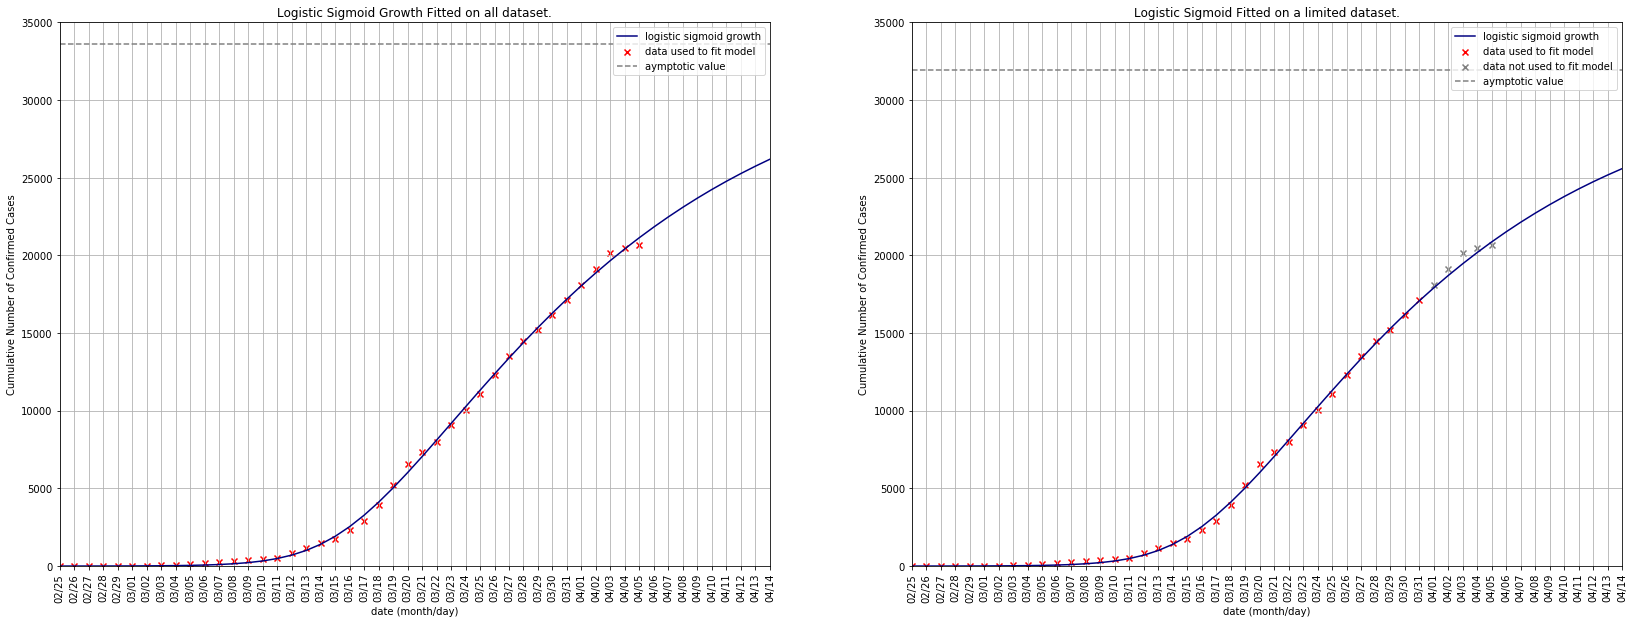

In [21]:
plt.figure(figsize=[28,10])

ax = ax_growth_model(ch_df.cumulative_cases, (logistic_sig_predictions[0],), subplot=121, asymptote=33589)
ax.set_ylim((0, 35000))
ax.set_title('Logistic Sigmoid Growth Fitted on all dataset.')

ax = ax_growth_model(ch_df.cumulative_cases, (logistic_sig_predictions[1],), subplot=122, fit_up_to=-5, asymptote=31937)
ax.set_ylim((0, 35000))
ax.set_title('Logistic Sigmoid Fitted on a limited dataset.')

plt.show()

#### Observations

Judging for the R2_score, The logistic sigmoid model offers similar performance as the richard equation on the training set however their performance are very different on the testing set. The logistic sigmoid managed to achieve a R2_score almost two times above the Richard Growth equation.

Another interesting thing to note is that the asymptotic value seems much less impacted by removing a few data points as it is the case with the Richard Growth and Logistic Growth models.

Now we can compare each of this model and try to predict the asymptotic value.

## 5. Models Comparison

In this section I will briefly compare the Logisitic Model, the Richard Growth Model and the logistic Sigmoid Model in order to predict next values.

This tables summarize the performance in terms of R2_score of each model on the full training set, on a reduced training* set and on the remaining testing set.

| Model                  | R2 on full data | R2 on training data | R2 on testing data |
|------------------------|:---------------:|:-------------------:|:------------------:|
|Logistic Growth         |0.9973           |0.9970               |0.3141              |
|Richard Growth          |0.9992           |0.9988               |0.4174              |
|Logistic Sigmoid Growth |**0.9993**       |**0.9991**           |**0.8346**          |

*the reduce training set is missing the last 5 values

Based on this values, the logisitic sigmoid growth seems to outperform  both the logistic growth and the Richard growth especially on the testing data.


In order to do predict, we plot side by side the different model fitted on the overall dataset and observe their asymptotic upper limit K:

In [32]:
t = ch_df.t.values
y = ch_df.cumulative_cases.values

models_tup = (LogisticGrowth, RichardGrowth, LogisticSigmoidGrowth)
params_tup = ({"a": 1.0,"t_0": 15.0,"K": max(y)}, {"a": 0.3, "b": 3.0, "d": 15.0, "K": 14000}, {"a": 0.3,"c": 3.0,"K": max(y)})
bounds_tup = (((0.0, 0.0, max(y)), (10.0, 100.0, 1000000.0)), (0.0, (10.0, 10.0, 100.0, 1000000.0)), ((0.0, -10.0, max(y)), (10.0, 10.0, 1000000.0)))
names_tup = ('logistic growth', 'richard growth', 'logistic sigmoid growth')
colors_tup = ('steelblue', 'royalblue', 'navy')


predictions = []
for model, params, bounds, name, color in zip(models_tup, params_tup, bounds_tup, names_tup, colors_tup):
    predictions.append(fit_growth_model(model, params, bounds, t, y, name, color, predict_up_to=70)[0])

[OPTIMISED params (full dataset)]
{'a': 0.21818564827934298, 't_0': 29.005788798428572, 'K': 22349.130985830536}
R2 SCORE (full dataset): 0.9975708189000357
[OPTIMISED params (full dataset)]
{'a': 2.558200012147715, 'b': 0.04359478770876352, 'd': 1.6990937536206987e-12, 'K': 27335.166438188407}
R2 SCORE (full dataset): 0.9992039992543896
[OPTIMISED params (full dataset)]
{'a': 0.41867536827688834, 'c': 6.835481487296738, 'K': 33588.847278336856}
R2 SCORE (full dataset): 0.9992910462335577


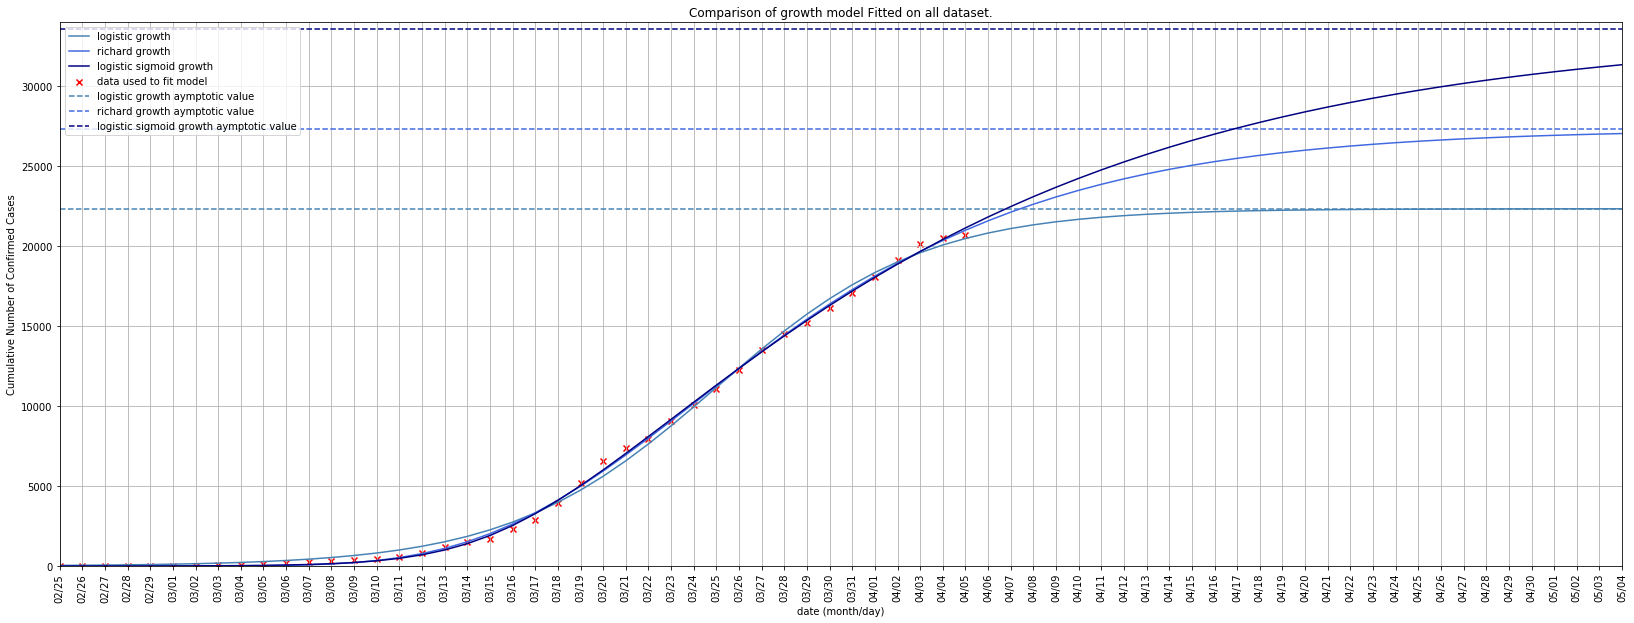

In [33]:
import datetime
plt.figure(figsize=[28,10])

ax = ax_growth_model(ch_df.cumulative_cases, predictions)

ax.hlines(22349, datetime.datetime(2020, 2, 25), datetime.datetime(2020, 5, 25), color="steelblue", linestyle="--", label="logistic growth aymptotic value")
ax.hlines(27335, datetime.datetime(2020, 2, 25), datetime.datetime(2020, 5, 25), color="royalblue", linestyle="--", label="richard growth aymptotic value")
ax.hlines(33589, datetime.datetime(2020, 2, 25), datetime.datetime(2020, 5, 25), color="navy", linestyle="--", label="logistic sigmoid growth aymptotic value")

ax.legend()

ax.set_ylim((0, 34000))
ax.set_title('Comparison of growth model Fitted on all dataset.')


plt.show()

#### Observations

The different models brings very different asymptotic values which will be almost reached on very different dates. We can conlude this analysis by looking at confidence interval on K the asymptotic value for the 3 different models.

#### Confidence intervals for K of different models.

We will compute confidence interval using bootstrapping [4] similarly to previous work on count data in [5] using a poisson distribution to simulate error and to generate bootstrap samples.

After fitting on 500 simulated samples using bootstrapping, we will consider that the central limit theroem is verified and that the distribution of K is following a Gaussian distribution in order to find 95% Confidence Interval.

**References**

[4] Efron B& Tibshirani R. 1986 "Bootstrap methods for standard errors, confidence intervals, and other measures of statistical accuracy." Stat. Sci 1, 54–75.

[5] Gerardo Chowell, Hiroshi Nishiura and Luís M.A Bettencourt 2006 "Comparative estimation of the reproduction number for pandemic influenza from daily case notification data"

In [50]:
# find 95% confidence interval for K for all 3 models
sim_num = 500

for Model, params, bounds, name in zip(models_tup, params_tup, bounds_tup, names_tup):
    
    model = Model(params, bounds)
    model.y_0 = 1.0
    results = np.zeros(sim_num)
    
    for i in range(sim_num):
        y = ch_df.daily_increase.apply(lambda increase: poisson.rvs(increase)).cumsum()
        t = ch_df.daily_increase.index.values

        model.fit(t, y)
        
        results[i] = model.params['K']
    print("{} has K = {} +/- {}".format(name, int(results.mean().round()), 1.96 * results.std() / sqrt(sim_num)))

logistic growth has K = 22348 +/- 15.169116768684642
richard growth has K = 27298 +/- 24.976896636070936
logistic sigmoid growth has K = 33596 +/- 75.05274630864139


In [54]:
limit_tup = (22348, 27298, 33596)

for Model, params, bounds, name, limit in zip(models_tup, params_tup, bounds_tup, names_tup, limit_tup):
    model = Model(params, bounds)
    model.y_0 = 1.0
    model.fit(t, y)
    
    i = 0
    while True:
        i += 1
        if model.compute_y(np.array([i]))[0] >= limit:
            break
    
    print("{} achieved asymptotic value {} in {} days on {}".format(name, limit, i, datetime.datetime(2020, 2, 25) + timedelta(days=i)))


logistic growth achieved asymptotic value 22348 in 50 days on 2020-04-15 00:00:00
richard growth achieved asymptotic value 27298 in 63 days on 2020-04-28 00:00:00
logistic sigmoid growth achieved asymptotic value 33596 in 77 days on 2020-05-12 00:00:00


#### observations

Confidence interval are larger with logistic sigmoid growth which means that small variation in the data has more impact on the asymptotic value K.

Relatively speaking the variability of the values are rather small (always less than 1% of the absolute value).

As expected, the date at which no increase will be measured are very different with each models.

## 6.Conclusions

In this study we tried to fit exponential models to the number of covid-19 cumulative cases in Switzerland.

By fitting simple exponential models we realised quickly that the overall trend is not exponential anymore even though it was at the beginning of the outbreak.

Using models that could account for the decay in the increase of cases (namely logistic, richard and logistic sigmoid growth) we explained and fit the data in a much better way. However we saw that until the spike of the increase of cases is not reach the asymptotic upper limit of this model is very hard to predict.

We nevertheless estimated asymptotic upper limit for each model and assessed them using 95% confidence interval. We predicted the number of days the outbreak will persist according to each model and to what date that was corresponding to.

<br>

**Disclaimer:**

Of course the conclusion drawn here are very dependent from many factors which are not included in this study such as social distancing and other measure taken by the governement, herd immunity...

<br>

**Another Approach / Futur Works:**

Another approach at predicting asymptotic value could have been to use countries which has already reached their asymptotic value and other features country based in order to predict using traditional regression the asymptotic value that we would obtain in Switzerland.
